In [1]:
import collections
import math

import torch
from d2l import torch as d2l
from torch import nn

In [2]:
class MTFraEng(d2l.DataModule):
    """The English-French dataset."""

    def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128):
        super(MTFraEng, self).__init__()
        self.save_hyperparameters()
        self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(
            self._download())

    def _download(self):
        d2l.extract(d2l.download(
            d2l.DATA_URL + 'fra-eng.zip', self.root, '94646ad1522d915e7b0f9296181140edcf86a4f5'))
        with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
            return f.read()

    def _preprocess(self, text):
        # Replace non-breaking space with space
        text = text.replace('\u202f', ' ').replace('\xa0', ' ')
        # Insert space between words and punctuation marks
        no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
        out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
               for i, char in enumerate(text.lower())]
        return ''.join(out)

    def _tokenize(self, text, max_examples=None):
        src, tgt = [], []
        for i, line in enumerate(text.split('\n')):
            if max_examples and i > max_examples: break
            parts = line.split('\t')
            if len(parts) == 2:
                # Skip empty tokens
                src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
                tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
        return src, tgt

    def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
        def _build_array(sentences, vocab, is_tgt=False):
            pad_or_trim = lambda seq, t: (
                seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
            sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
            if is_tgt:
                sentences = [['<bos>'] + s for s in sentences]
            if vocab is None:
                vocab = d2l.Vocab(sentences, min_freq=2)  # discard the tokens with freq < 2
            array = torch.tensor([vocab[s] for s in sentences])
            valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
            return array, vocab, valid_len

        src, tgt = self._tokenize(self._preprocess(raw_text),
                                  self.num_train + self.num_val)
        src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
        tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
        return ((src_array, tgt_array[:, :-1], src_valid_len, tgt_array[:, 1:]),
                src_vocab, tgt_vocab)

    def get_dataloader(self, train):
        idx = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader(self.arrays, train, idx)

    def build(self, src_sentences, tgt_sentences):
        raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(
            src_sentences, tgt_sentences)])
        arrays, _, _ = self._build_arrays(
            raw_text, self.src_vocab, self.tgt_vocab)
        return arrays

### Data preparation

1. download the data
2. preprocess: (a) Replace non-breaking space with space; (b) Insert space between words and punctuation marks
3. tokenization and generate source and target sequences. <span style="color:red">Here</span> we keep the punctuation marks.

In [3]:
torch.manual_seed(123)

batch_size = 10
num_steps = 9
data = MTFraEng(batch_size, num_steps)
raw_text = data._download()
print(f'raw_text[:75]: {raw_text[:75]}')

text = data._preprocess(raw_text)
print(f'text[:80]: {text[:80]}')

src, tgt = data._tokenize(text)
print(f'src[:6]: {src[:6]}')
print(f'tgt[:6]: {tgt[:6]}')

raw_text[:75]: Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !

text[:80]: go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !
src[:6]: [['go', '.', '<eos>'], ['hi', '.', '<eos>'], ['run', '!', '<eos>'], ['run', '!', '<eos>'], ['who', '?', '<eos>'], ['wow', '!', '<eos>']]
tgt[:6]: [['va', '!', '<eos>'], ['salut', '!', '<eos>'], ['cours', '!', '<eos>'], ['courez', '!', '<eos>'], ['qui', '?', '<eos>'], ['ça', 'alors', '!', '<eos>']]


### _build_arrays

```
    def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
        def _build_array(sentences, vocab, is_tgt=False):
            pad_or_trim = lambda seq, t: (
                seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
            sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
            if is_tgt:
                sentences = [['<bos>'] + s for s in sentences]
            if vocab is None:
                vocab = d2l.Vocab(sentences, min_freq=2)  # discard the tokens with freq < 2
            array = torch.tensor([vocab[s] for s in sentences])
            valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
            return array, vocab, valid_len

        src, tgt = self._tokenize(self._preprocess(raw_text),
                                  self.num_train + self.num_val)
        src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
        tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
        return ((src_array, tgt_array[:, :-1], src_valid_len, tgt_array[:, 1:]),
                src_vocab, tgt_vocab)
```

1. pad_or_trim: To control sentence length, we <font color='red'>truncate</font> long sentences and <font color='red'>pad</font> short ones.
2. ```vocab = d2l.Vocab(sentences, min_freq=2)``` <font color='red'>Discard</font> the tokens with freq < 2.
3. Return. The 1st component: ```(src_array, tgt_array[:, :-1], src_valid_len, tgt_array[:, 1:])```. <br>
   ```tgt_array[:, :-1]``` <-> dec_input <br>
   ```tgt_array[:, 1:]``` <-> dec_output <br>

In [4]:
src, tgt, src_valid_len, label = next(iter(data.train_dataloader()))
print(f'data.src_vocab.token_to_idx: {data.src_vocab.token_to_idx}')
print(f'data.tgt_vocab.token_to_idx: {data.tgt_vocab.token_to_idx}')

data.src_vocab.token_to_idx: {'!': 0, ',': 1, '.': 2, '<eos>': 3, '<pad>': 4, '<unk>': 5, '?': 6, 'a': 7, 'agree': 8, 'ahead': 9, 'am': 10, 'ask': 11, 'attack': 12, 'away': 13, 'back': 14, 'bark': 15, 'be': 16, 'beats': 17, 'bed': 18, 'beg': 19, 'busy': 20, 'call': 21, 'calm': 22, 'came': 23, 'can': 24, 'catch': 25, 'cheers': 26, 'cold': 27, 'come': 28, 'cool': 29, 'cringed': 30, 'deaf': 31, 'did': 32, 'die': 33, 'died': 34, 'dogs': 35, "don't": 36, 'down': 37, 'dozed': 38, 'drive': 39, 'drop': 40, 'excuse': 41, 'fair': 42, 'fat': 43, 'feel': 44, 'fell': 45, 'find': 46, 'fine': 47, 'fire': 48, 'fix': 49, 'follow': 50, 'for': 51, 'forget': 52, 'free': 53, 'full': 54, 'fun': 55, 'game': 56, 'get': 57, 'give': 58, 'go': 59, 'good': 60, 'got': 61, 'grab': 62, 'had': 63, 'hang': 64, 'have': 65, 'he': 66, "he's": 67, 'hello': 68, 'help': 69, 'here': 70, 'hi': 71, 'him': 72, 'his': 73, 'hit': 74, 'hold': 75, 'home': 76, 'hop': 77, 'hot': 78, 'how': 79, "how's": 80, 'hug': 81, 'hurried': 82, '

In [5]:
print('source:', src.type(torch.int32))
print('tgt:', tgt.type(torch.int32))

source: tensor([[ 86,  20,   2,   3,   4,   4,   4,   4,   4],
        [ 84,  32, 120,   2,   3,   4,   4,   4,   4],
        [ 86,   5,   2,   3,   4,   4,   4,   4,   4],
        [ 28, 150,   2,   3,   4,   4,   4,   4,   4],
        [ 16, 153,   2,   3,   4,   4,   4,   4,   4],
        [ 84, 172,   2,   3,   4,   4,   4,   4,   4],
        [  5,   2,   3,   4,   4,   4,   4,   4,   4],
        [ 84, 170,   2,   3,   4,   4,   4,   4,   4],
        [ 35,  15,   2,   3,   4,   4,   4,   4,   4],
        [ 86, 121,   2,   3,   4,   4,   4,   4,   4]], dtype=torch.int32)
tgt: tensor([[  3, 108, 183,   6,   2,   4,   5,   5,   5],
        [  3, 108, 122, 183,  30,   6,   2,   4,   5],
        [  3, 108, 183,   6,   2,   4,   5,   5,   5],
        [  3, 204,  31,   0,   4,   5,   5,   5,   5],
        [  3, 182,  39,   0,   4,   5,   5,   5,   5],
        [  3,   6,   2,   4,   5,   5,   5,   5,   5],
        [  3, 128,   0,   4,   5,   5,   5,   5,   5],
        [  3,   6,   2,   4,   5

In [6]:
print('source[0]:', data.src_vocab.to_tokens(src[0].type(torch.int32)))
print('target[0]:', data.tgt_vocab.to_tokens(tgt[0].type(torch.int32)))

source[0]: ["i'm", 'busy', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
target[0]: ['<bos>', 'je', 'suis', '<unk>', '.', '<eos>', '<pad>', '<pad>', '<pad>']


In [7]:
print('source len excluding pad:', src_valid_len.type(torch.int32))
print('label:', label.type(torch.int32))

source len excluding pad: tensor([4, 5, 4, 4, 4, 4, 3, 4, 4, 4], dtype=torch.int32)
label: tensor([[108, 183,   6,   2,   4,   5,   5,   5,   5],
        [108, 122, 183,  30,   6,   2,   4,   5,   5],
        [108, 183,   6,   2,   4,   5,   5,   5,   5],
        [204,  31,   0,   4,   5,   5,   5,   5,   5],
        [182,  39,   0,   4,   5,   5,   5,   5,   5],
        [  6,   2,   4,   5,   5,   5,   5,   5,   5],
        [128,   0,   4,   5,   5,   5,   5,   5,   5],
        [  6,   2,   4,   5,   5,   5,   5,   5,   5],
        [  6,  48,   9,   2,   4,   5,   5,   5,   5],
        [108, 127, 152,  30,   2,   4,   5,   5,   5]], dtype=torch.int32)


### The Encoder-Decoder Seq2Seq Architecture

Paper: [Sequence to Sequence Learning with Neural Networks, 2014](https://arxiv.org/pdf/1409.3215.pdf)

input -> encoder -> state -> decoder (<- input) -> output

1. **encoder**: enc_input -> enc_outputs
2. **decoder**: dec_input $\times$ dec_state -> dec_outputs <br>
   **dec_init_state**: enc_outputs -> dec_state

In [8]:
class Encoder(nn.Module):
    """The base encoder interface for the encoder-decoder architecture."""

    def __init__(self):
        super().__init__()

    # Later there can be additional arguments (e.g., length excluding padding)
    def forward(self, X, *args):
        raise NotImplementedError

In [9]:
class Decoder(nn.Module):
    """The base decoder interface for the encoder-decoder architecture."""

    def __init__(self):
        super().__init__()

    # Later there can be additional arguments (e.g., length excluding padding)
    def init_state(self, enc_all_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [10]:
class EncoderDecoder(d2l.Classifier):
    """The base class for the encoder-decoder architecture."""

    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_all_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        # Return decoder output only
        return self.decoder(dec_X, dec_state)[0]

In [11]:
def init_seq2seq(module):
    """Initialize weights for Seq2Seq."""
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

In [12]:
class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence to sequence learning."""

    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

In [13]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""

    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size + num_hiddens, num_hiddens,
                           num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        """
        :param enc_all_outputs: (outputs, state)
        """
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]  # enc_output at the final time step
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)  # the dimension over which the tensors are concatenated
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

### Seq2SeqDecoder

1. Use the enc_output at the final time step as the **context**: ```context = enc_output[-1]``` <br>
   **hidden_state** shape: (num_layers, batch_size, num_hiddens) <br>
   **enc_output** shape: (num_steps, batch_size, num_hiddens) <br>
   **context shape**: (batch_size, num_hiddens) <br>

![deep_rnn](figure/deep_rnn.png)

**REMARK** When there is no output_layer, the **context** $O_T$ is equal to the state at the final time step in $L$th layer $H_T^{(L)}$: ```context``` equals ```hidden_state[-1]```.

2. Broadcast context: ```context = context.repeat(embs.shape[0], 1, 1)```. Say the original context has shape: (batch_size, num_hiddens), the broadcasted context has shape: (num_steps, batch_size, num_hiddens)
3. Concate the embedded dec_input and the broadcasted context: ```embs_and_context = torch.cat((embs, context), -1)```. The embs has shape: (num_steps, batch_size, embed_size), and the broadcasted context has shape: (num_steps, batch_size, num_hiddens). Then embs_and_context has shape: (num_steps, batch_size, embed_size + num_hiddens)
4. Pass embs_and_context and hidden_state to dec_rnn: ```self.rnn(embs_and_context, hidden_state)```. <br>
Recall that hidden_state here is the enc_state: ```enc_output, hidden_state = state```. <br>
By (3) and (4), we have ```self.rnn = d2l.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout)```

### init_seq2seq

1. nn.linear: in_features $\times$ out_features -> (\*, out_features) <br>
   input: (*, in_features) <br>
   output: (\*, out_features) <br>
   $y = x A^{T} + b$
2. by default, bias = True

In [14]:
in_feas, out_feas, num_input = 2, 3, 10
m = nn.Linear(in_feas, out_feas)
input = torch.randn(num_input, in_feas)
output = m(input)
print(f'output.shape: {output.shape}')
print(f'm.weight.shape, m.bias.shape: {m.weight.shape, m.bias.shape}')

output.shape: torch.Size([10, 3])
m.weight.shape, m.bias.shape: (torch.Size([3, 2]), torch.Size([3]))


### nn.Embedding

1. nn.Embedding: num_embeddings $\times$ embedding_dim, OR vocab_size $\times$ vector_size
2. num_embeddings: size of the dictionary of embeddings
3. embedding_dim: the size of each embedding vector
4. input: (*), IntTensor or LongTensor of arbitrary shape containing the indices to extract
5. output: (*, H), where * is the input shape and H = embedding_dim
6. vocab_size > any element in input

In [15]:
vocab_size, emb_size = 10, 3
embedding = nn.Embedding(vocab_size, emb_size)
# a batch of 2 samples of 4 indices each
input = torch.LongTensor([[1, 2, 4, 0], [4, 3, 2, 9]])
embedding(input)

tensor([[[-1.2203,  1.3139,  1.0533],
         [ 0.1388, -0.2044, -0.8036],
         [-0.7979,  0.1838,  1.6863],
         [ 1.6221, -1.4779,  1.1331]],

        [[-0.7979,  0.1838,  1.6863],
         [-0.2808,  0.7697, -0.6596],
         [ 0.1388, -0.2044, -0.8036],
         [-0.5951, -0.7112,  0.6230]]], grad_fn=<EmbeddingBackward0>)

Let us take the 1st batch in the input ```[1, 2, 4, 0]``` as an example. Its embedding matrix (4 by 3) is a re-representation of the raw data.nts 

### Encoder

In [16]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)
d2l.check_shape(enc_outputs, (num_steps, batch_size, num_hiddens))
d2l.check_shape(enc_state, (num_layers, batch_size, num_hiddens))
print(f'enc_outputs.shape: {enc_outputs.shape}')
print(f'enc_state.shape: {enc_state.shape}')

enc_outputs.shape: torch.Size([9, 4, 16])
enc_state.shape: torch.Size([2, 4, 16])


num_layers is the number of layers in the deep RNNs

### Decoder

In [17]:
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)
d2l.check_shape(dec_outputs, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[1], (num_layers, batch_size, num_hiddens))

C:\Users\billt\PycharmProjects\DeepLearning\dl_venv\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Encoder-Decoder for Sequence to Sequence Learning

In [18]:
class Seq2Seq(d2l.EncoderDecoder):
    """The RNN encoder-decoder for sequence to sequence learning."""

    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def loss(self, Y_hat, Y):
        l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
        mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
        return (l * mask).sum() / mask.sum()

### Loss Function with Masking

- Recall that the special **padding tokens** are appended to the end of sequences so sequences of varying lengths can be efficiently loaded in
minibatches of the same shape. <br>
- Prediction of padding tokens should be excluded from loss calculations.

Here ```data.tgt_vocab['<pad>'] = 5``` and ```Y.reshape(-1): tensor([6, 0, 4,  ..., 5, 5, 5], device='cuda:0')```. We only calculate the loss on the non-padding tokens: ```mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)```. 

### Training

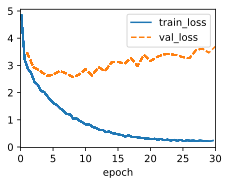

In [19]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

### Prediction

1. The predicted token from the previous time step is fed into the decoder as an input. <br>
2. A simple **greedy** strategy is to use whichever token the decoder has assigned the **highest probability** when predicting at each step. <br>
3. In practice, we **beam search** instead of the greedy strategy.

```
    @d2l.add_to_class(d2l.EncoderDecoder)
    def predict_step(self, batch, device, num_steps,
                     save_attention_weights=False):
        """Defined in :numref:`sec_seq2seq_training`"""
        batch = [d2l.to(a, device) for a in batch]
        src, tgt, src_valid_len, _ = batch
        enc_all_outputs = self.encoder(src, src_valid_len)
        dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
        outputs, attention_weights = [d2l.expand_dims(tgt[:, 0], 1), ], []
        for _ in range(num_steps):
            Y, dec_state = self.decoder(outputs[-1], dec_state)
            outputs.append(d2l.argmax(Y, 2))
            # Save attention weights (to be covered later)
            if save_attention_weights:
                attention_weights.append(self.decoder.attention_weights)
        return d2l.concat(outputs[1:], 1), attention_weights
```

In [20]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)

Y.shape: torch.Size([4, 1, 214])
Y.shape: torch.Size([4, 1, 214])
Y.shape: torch.Size([4, 1, 214])
Y.shape: torch.Size([4, 1, 214])
Y.shape: torch.Size([4, 1, 214])
Y.shape: torch.Size([4, 1, 214])
Y.shape: torch.Size([4, 1, 214])
Y.shape: torch.Size([4, 1, 214])
Y.shape: torch.Size([4, 1, 214])


1. Here ```data.num_steps = 9``` and ```len(data.tgt_vocab) = 214```
2. Given 4 English words, for each word, give its French translation with max size 9: ```Y.shape: torch.Size([4, 1, 214])```
3. The greedy strategy: ```outputs.append(d2l.argmax(Y, 2))```

**REMARK**. In principle, ```predict_step``` should not access the target language ```tgt```. But note that ```tgt[:, 0]``` corresponds the 1st token in all the sentences: '<bos>'

### Evaluation of Predicted Sequences

1. BLEU (Bilingual Evaluation Understudy, 双语互译质量评估辅助工具) has been extensively used in measuring the quality
of output sequences for different applications.
2. BLEU evaluates whether this n-grams appears in the target sequence.e.

**Example**. Given a target sequence A, B, C, D, E, F, and a predicted sequence A, B, B, C, D. <br>
1. 4 of the 5 unigrams in the predicted sequence (A,B,B,C,D) macthe the target sequence. Denote $p_1 = 4/5$ <br>
2. 3 of the 4 bigrams in the predicted sequence (AB,BB,BC,CD) macthe the target sequence: $p_2 = 3/4$ <br>
3. 1 of the 3 trigrams in the predicted sequence (ABB,BBC,BCD) macthe the target sequence: $p_3 = 1/3$ <br>
4. 0 of the 2 4-grams in the predicted sequence (ABBC,BBCD) macthe the target sequence: $p_4 = 0$    

Let lenlabel and lenpred be 
the numbers of tokens in the target sequence and the predicted sequenc. BLEU is defined as
\begin{equation}
    \exp{(\min{(0, 1 - \frac{lenlabel}{lenpred})})} \prod_{n=1}^{k}{p_n^{1/2^n}},
\end{equation}
where $k$ is the longest n-grams for matching.,

1. For a perfect match, its BLEU is 1.
2. Since matching longer n-grams is more difficult, BLEU assigns a greater weight to a longer n-gram precision. When $p_n$ is
fixed, $p_n^{1/2^n}$ increases as $n$ grows: Suppose $p_n=0.5$, then $0.707=0.5^{1/}< 0.5^{1/102}= 0.99$ 

3. Since predicting shorter sequences tends to obtain a higher $p_n$ value, the coefficient before the multiplication term penalizes shorter predicted sequences.
**Example**. When $k = 2$, given the target sequence A, B, C, D, E, F and the predicted sequence A, B, then <br>
lenlabel=6 and lenpred=2. Although $p_1=p_2=1$, the penality factor $\exp{(1-6/2)}=0.14$ lowers BLEU

In [21]:
def bleu(pred_seq, label_seq, k):
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
    for i in range(len_label - n + 1):
        label_subs[' '.join(label_tokens[i: i + n])] += 1
    for i in range(len_pred - n + 1):
        if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
            num_matches += 1
            label_subs[' '.join(pred_tokens[i: i + n])] -= 1
    score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [22]:
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.760
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000
